# Modeling: Predicting Packaging Quality

**Objective:** After completing the data cleaning and feature engineering steps, we proceeded to train and evaluate predictive models to classify packaging quality (`Good` vs. `Bad`). This section describes the modeling pipeline and key performance results.


In [ ]:
from google.colab import files
feature_engineered_data = files.upload()

Saving feature_engineered_data.csv to feature_engineered_data (1).csv


## 1. Data preparation

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# Load feature-engineered data
df = pd.read_csv("feature_engineered_data.csv")
print(df.dtypes.value_counts())

# Identify float64 and int64 columns
float_cols = df.select_dtypes(include='float64').columns.tolist()
int_cols = df.select_dtypes(include='int64').columns.tolist()
# Downcast float64 to float32
for col in float_cols:
    df[col] = pd.to_numeric(df[col], downcast='float')
# Downcast int64 to int16 if within range
for col in int_cols:
    min_val, max_val = df[col].min(), df[col].max()
    if min_val >= -32768 and max_val <= 32767:
        df[col] = df[col].astype('int16')
    else:
        print(f"⚠️ Skipping '{col}' (out of int16 range): min={min_val}, max={max_val}")
print(df.dtypes.value_counts())

# Fill missing Target values with 0 (assumed bad quality)
df['Target'] = df['Target'].fillna(0)
# Ensure it's still a float or integer type if needed
df['Target'] = df['Target'].astype(int)


# Separate features and target
X = df.drop(columns=['Target'])
y = df['Target']

# Train-test split (stratified due to class imbalance)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

bool       53
float64    12
int64      10
Name: count, dtype: int64
bool       53
float32    12
int16      10
Name: count, dtype: int64


- We loaded the final dataset from `feature_engineered_data.csv`.
- The target variable `Target` was separated from the predictors.
- We split the data into training and test sets (80/20 split), using **stratified sampling** to preserve class balance due to the imbalance between “Good” and “Bad” labels.

### Delete supplier history rate
- **Action**: Evaluate whether the SupplierHistoryScore is useful.

- **How**:
  - Check correlation with the target (Target).
  - Try with/without this feature in initial models to see if it helps or not.

In [ ]:
# Compute correlation
correlation = df['SupplierHistoryScore'].corr(df['Target'])
print(f"🔍 Correlation between SupplierHistoryScore and Target: {correlation:.3f}")

🔍 Correlation between SupplierHistoryScore and Target: 0.013


✅ Interpretation:
- This suggests that there is almost no linear relationship between `SupplierHistoryScore`and `Target`.

In other words, `SupplierHistoryScore` doesn’t seem to predict whether the packaging quality is “Good” (1) or “Bad” (0) linearly.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
df = pd.read_csv("feature_engineered_data.csv")

# Drop unneeded columns and check object columns
df = df.drop(columns=['SupplierName', 'ProposedFoldingMethod', 'ProposedLayout', 'Month', 'MonthName', 'Weekday', 'SupplierHistoryRate'], errors='ignore')
df = df.dropna(subset=['Target'])
leakage_cols = ['PackagingQuality_Bin', 'PackagingQuality_Clean']
df = df.drop(columns=[col for col in leakage_cols if col in df.columns])

# Features and target
X = df.drop(columns=['Target'])
y = df['Target']

# Initialize results DataFrame
results_df = pd.DataFrame(columns=[
    'Model', 'Split_Type', 'Split_Seed', 'Train_Accuracy', 'Test_Accuracy',
    'Train_ConfusionMatrix', 'Test_ConfusionMatrix', 'ROC_AUC', 'Notes'
])

categorical_cols = X.select_dtypes(include='object').columns

# Evaluation Function
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name, split_type, seed, notes='', retrain=True):
    if retrain:
        model.fit(X_train, y_train)
    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    y_test_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
    # Metrics
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    train_cm = confusion_matrix(y_train, y_train_pred).tolist()
    test_cm = confusion_matrix(y_test, y_test_pred).tolist()
    roc_auc = roc_auc_score(y_test, y_test_proba) if y_test_proba is not None else np.nan
    # Save
    results_df.loc[len(results_df)] = [
        model_name, split_type, seed, train_acc, test_acc, train_cm, test_cm, roc_auc, notes
    ]
    # Print classification report
    print(f"=== {model_name} ({split_type}) ===")
    print(classification_report(y_test, y_test_pred))
    print("ROC-AUC:", roc_auc)
    # Plot confusion matrix
    sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True, fmt='d', cmap='Blues')
    plt.title(f"{model_name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
    # Plot feature importances if available
    if hasattr(model, 'feature_importances_'):
        importances = pd.Series(model.feature_importances_, index=X_train.columns)
        importances.nlargest(15).plot(kind='barh')
        plt.title(f"Top 15 Feature Importances - {model_name}")
        plt.gca().invert_yaxis()
        plt.show()

✅ Test 0: Baseline Models
=== RandomForest (Test0) ===
              precision    recall  f1-score   support

         0.0       0.39      0.07      0.12     19292
         1.0       0.81      0.97      0.88     77942

    accuracy                           0.79     97234
   macro avg       0.60      0.52      0.50     97234
weighted avg       0.73      0.79      0.73     97234

ROC-AUC: 0.6681669035806159


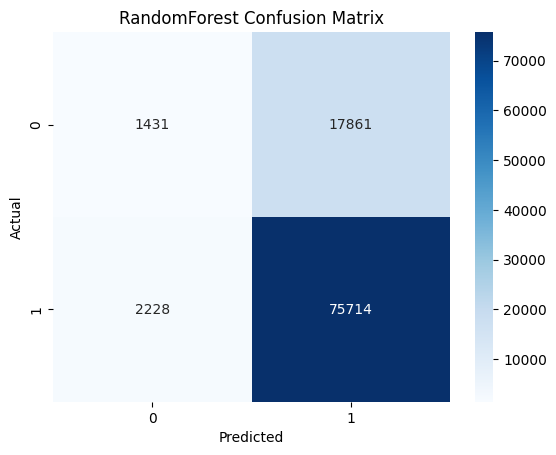

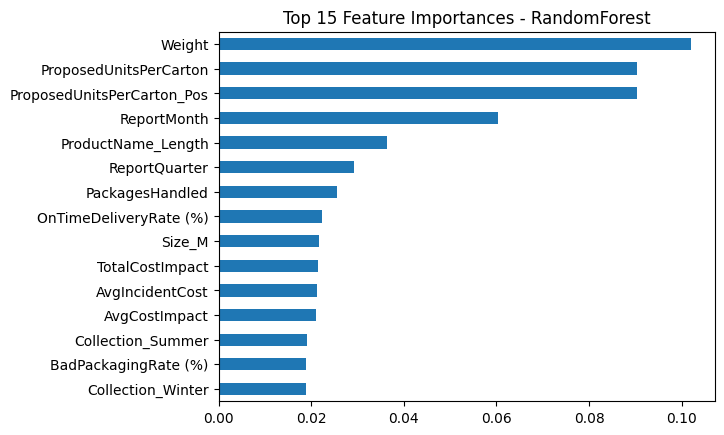

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:32:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


=== XGBoost (Test0) ===
              precision    recall  f1-score   support

         0.0       0.47      0.05      0.09     19292
         1.0       0.81      0.99      0.89     77942

    accuracy                           0.80     97234
   macro avg       0.64      0.52      0.49     97234
weighted avg       0.74      0.80      0.73     97234

ROC-AUC: 0.6982782352027045


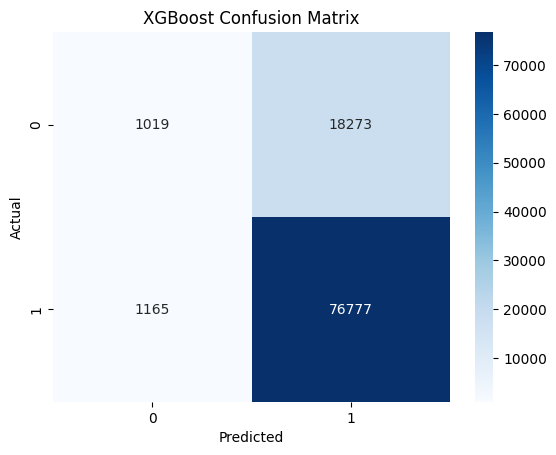

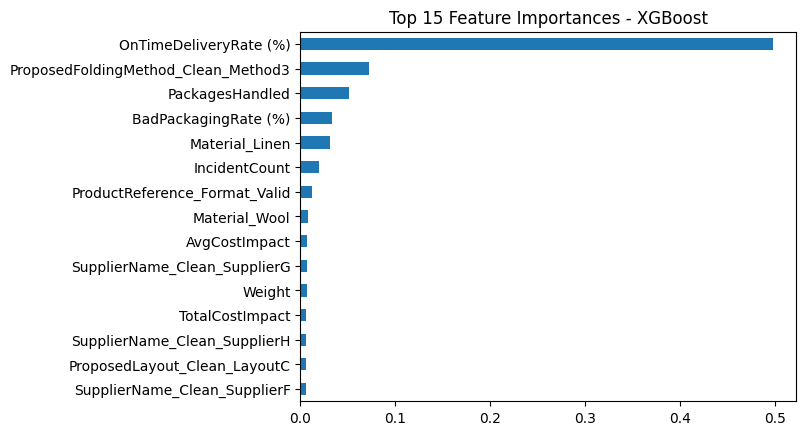

✅ Test 1: Random Seeds Splits (Ordinal Encoding)
=== RandomForest (RandomSeed) ===
              precision    recall  f1-score   support

         0.0       0.38      0.10      0.15     19294
         1.0       0.81      0.96      0.88     77940

    accuracy                           0.79     97234
   macro avg       0.60      0.53      0.52     97234
weighted avg       0.73      0.79      0.74     97234

ROC-AUC: 0.6621967793093639


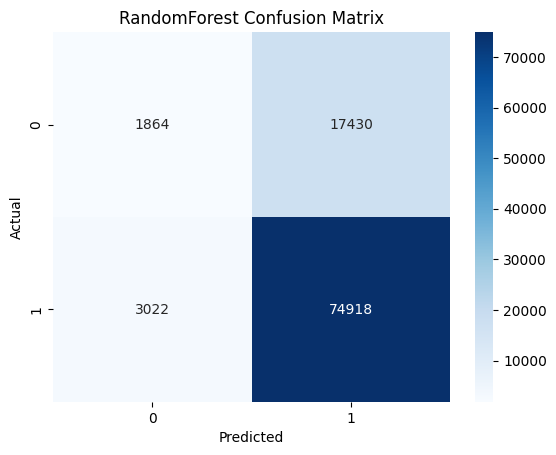

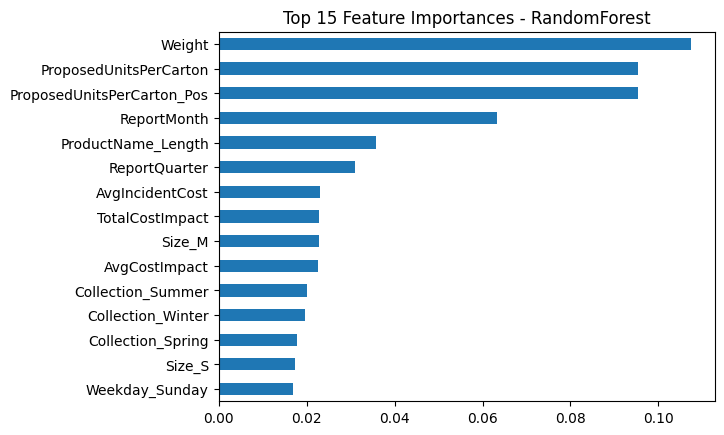

=== RandomForest (RandomSeed) ===
              precision    recall  f1-score   support

         0.0       0.37      0.09      0.15     19133
         1.0       0.81      0.96      0.88     78101

    accuracy                           0.79     97234
   macro avg       0.59      0.53      0.51     97234
weighted avg       0.73      0.79      0.74     97234

ROC-AUC: 0.6631105104129602


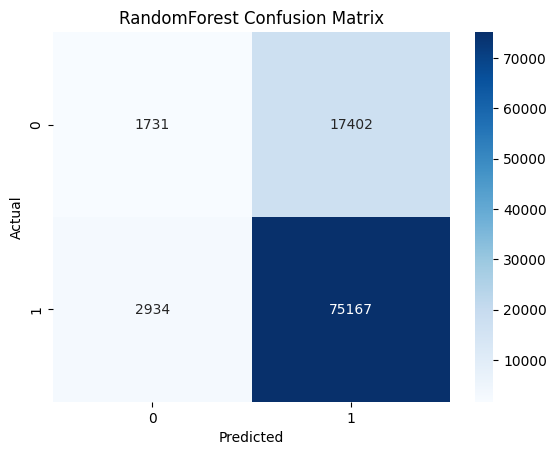

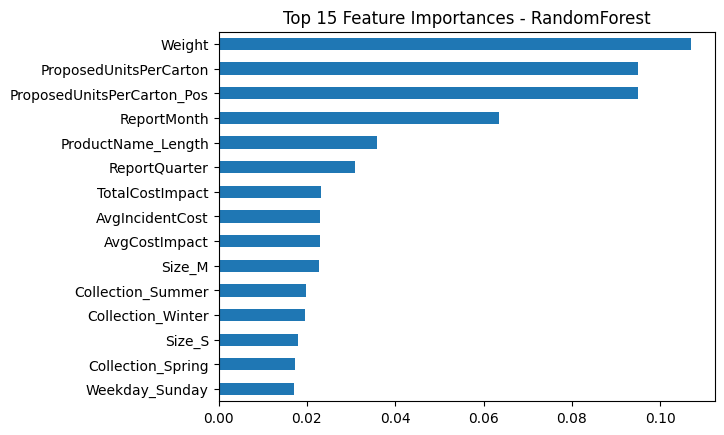

=== RandomForest (RandomSeed) ===
              precision    recall  f1-score   support

         0.0       0.39      0.10      0.15     19351
         1.0       0.81      0.96      0.88     77883

    accuracy                           0.79     97234
   macro avg       0.60      0.53      0.52     97234
weighted avg       0.73      0.79      0.74     97234

ROC-AUC: 0.6670542246257636


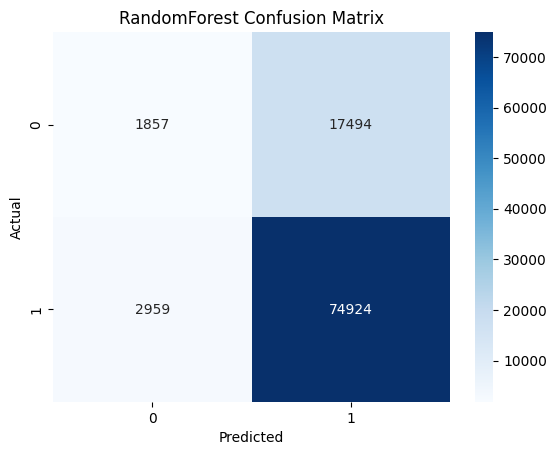

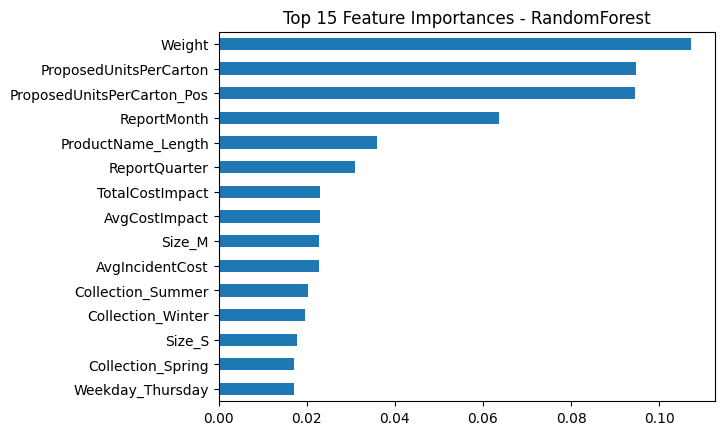

✅ Test 2: Temporal Split using ReportMonth
=== RandomForest (TemporalSplit) ===
              precision    recall  f1-score   support

         0.0       0.38      0.08      0.14     16326
         1.0       0.81      0.97      0.88     64983

    accuracy                           0.79     81309
   macro avg       0.59      0.52      0.51     81309
weighted avg       0.72      0.79      0.73     81309

ROC-AUC: 0.6646438008931365


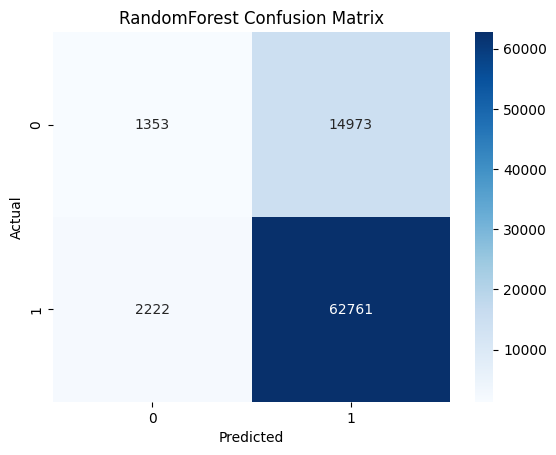

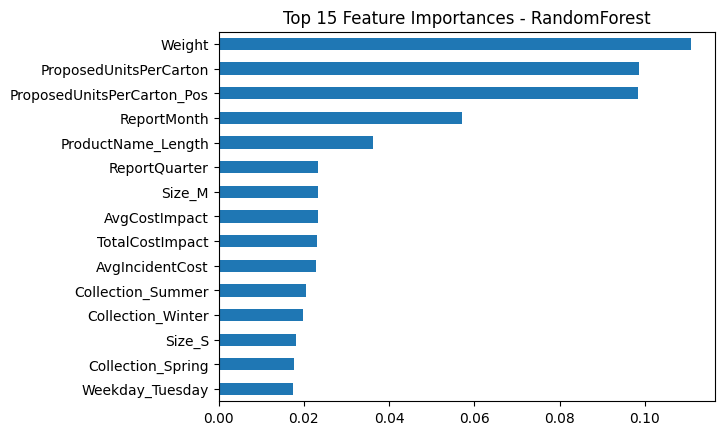

✅ Test 3: XGBoost with LabelEncoder


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:41:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


=== XGBoost (RandomSeed) ===
              precision    recall  f1-score   support

         0.0       0.57      0.03      0.05     19133
         1.0       0.81      1.00      0.89     78101

    accuracy                           0.80     97234
   macro avg       0.69      0.51      0.47     97234
weighted avg       0.76      0.80      0.73     97234

ROC-AUC: 0.7058579774580948


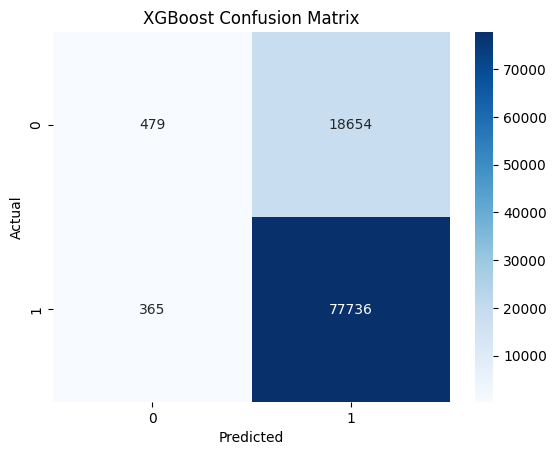

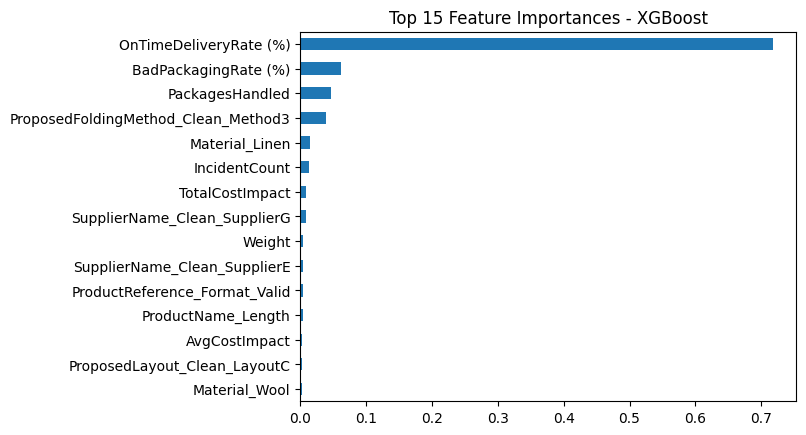

✅ Test 4: Logistic Regression (numerical features only, scaled)
=== LogisticRegression (RandomSeed) ===
              precision    recall  f1-score   support

         0.0       0.55      0.02      0.04     19133
         1.0       0.81      1.00      0.89     78101

    accuracy                           0.80     97234
   macro avg       0.68      0.51      0.47     97234
weighted avg       0.76      0.80      0.72     97234

ROC-AUC: 0.6951770008876085


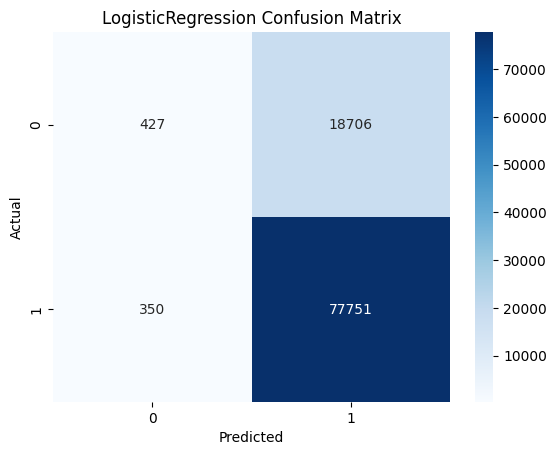

✅ Test 5: Class Imbalance Handling (undersampling)
=== RandomForest_Undersample (RandomSeed) ===
              precision    recall  f1-score   support

         0.0       0.29      0.66      0.40     19133
         1.0       0.88      0.59      0.71     78101

    accuracy                           0.61     97234
   macro avg       0.58      0.63      0.55     97234
weighted avg       0.76      0.61      0.65     97234

ROC-AUC: 0.6730726839479516


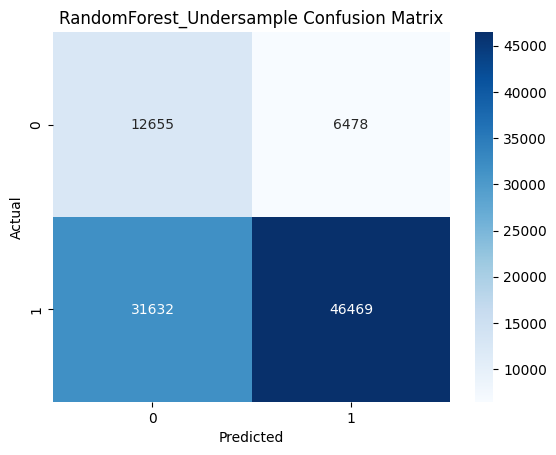

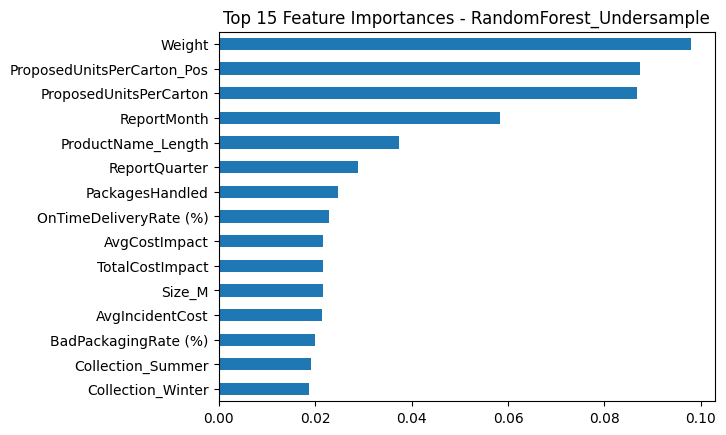

✅ Test 6: Random Forest Hyperparameter Tuning (GridSearchCV)
Fitting 4 folds for each of 24 candidates, totalling 96 fits


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
df = pd.read_csv("feature_engineered_data.csv")

# Drop unneeded columns and check object columns
df = df.drop(columns=['SupplierName', 'ProposedFoldingMethod', 'ProposedLayout', 'Month', 'MonthName', 'Weekday', 'SupplierHistoryRate'], errors='ignore')
df = df.dropna(subset=['Target'])
leakage_cols = ['PackagingQuality_Bin', 'PackagingQuality_Clean']
df = df.drop(columns=[col for col in leakage_cols if col in df.columns])

# Features and target
X = df.drop(columns=['Target'])
y = df['Target']

# Initialize results DataFrame
results_df = pd.DataFrame(columns=[
    'Model', 'Split_Type', 'Split_Seed', 'Train_Accuracy', 'Test_Accuracy',
    'Train_ConfusionMatrix', 'Test_ConfusionMatrix', 'ROC_AUC', 'Notes'
])

categorical_cols = X.select_dtypes(include='object').columns

# Evaluation Function
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name, split_type, seed, notes='', retrain=True):
    if retrain:
        model.fit(X_train, y_train)
    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    y_test_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
    # Metrics
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    train_cm = confusion_matrix(y_train, y_train_pred).tolist()
    test_cm = confusion_matrix(y_test, y_test_pred).tolist()
    roc_auc = roc_auc_score(y_test, y_test_proba) if y_test_proba is not None else np.nan
    # Save
    results_df.loc[len(results_df)] = [
        model_name, split_type, seed, train_acc, test_acc, train_cm, test_cm, roc_auc, notes
    ]
    # Print classification report
    print(f"=== {model_name} ({split_type}) ===")
    print(classification_report(y_test, y_test_pred))
    print("ROC-AUC:", roc_auc)
    # Plot confusion matrix
    sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True, fmt='d', cmap='Blues')
    plt.title(f"{model_name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
    # Plot feature importances if available
    if hasattr(model, 'feature_importances_'):
        importances = pd.Series(model.feature_importances_, index=X_train.columns)
        importances.nlargest(15).plot(kind='barh')
        plt.title(f"Top 15 Feature Importances - {model_name}")
        plt.gca().invert_yaxis()
        plt.show()

# 0️⃣ Test 0: Baseline RandomForest and XGBoost
print("✅ Test 0: Baseline Models")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
# RandomForest
rf = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced')
evaluate_model(rf, X_train, X_test, y_train, y_test, 'RandomForest', 'Test0', 42, 'Initial baseline')
# XGBoost
xgb = XGBClassifier(n_estimators=200, use_label_encoder=False, eval_metric='logloss', random_state=42)
evaluate_model(xgb, X_train, X_test, y_train, y_test, 'XGBoost', 'Test0', 42, 'Initial baseline')

# 1️⃣ Test 1: Random Seeds Splits & Encoding (Ordinal)
print("✅ Test 1: Random Seeds Splits (Ordinal Encoding)")
for seed in [0, 42, 123]:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
    X_train_enc, X_test_enc = X_train.copy(), X_test.copy()
    enc = OrdinalEncoder()
    X_train_enc[categorical_cols] = enc.fit_transform(X_train[categorical_cols])
    X_test_enc[categorical_cols] = enc.transform(X_test[categorical_cols])
    model_rf = RandomForestClassifier(random_state=seed)
    evaluate_model(model_rf, X_train_enc, X_test_enc, y_train, y_test, 'RandomForest', 'RandomSeed', seed)

# 2️⃣ Test 2: Temporal Split using ReportMonth
print("✅ Test 2: Temporal Split using ReportMonth")
train_data = df[df['ReportMonth'] <= 9]
test_data = df[df['ReportMonth'] > 9]
X_train = train_data.drop(columns=['Target'])
y_train = train_data['Target']
X_test = test_data.drop(columns=['Target'])
y_test = test_data['Target']
enc = OrdinalEncoder()
X_train[categorical_cols] = enc.fit_transform(X_train[categorical_cols])
X_test[categorical_cols] = enc.transform(X_test[categorical_cols])
model_rf = RandomForestClassifier(random_state=42)
evaluate_model(model_rf, X_train, X_test, y_train, y_test, 'RandomForest', 'TemporalSplit', None)

# 3️⃣ Test 3: XGBoost with LabelEncoder (with validation set for early stopping)
print("✅ Test 3: XGBoost with LabelEncoder")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
for col in categorical_cols:
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col])
    X_test[col] = le.transform(X_test[col])
X_train_xgb, X_val, y_train_xgb, y_val = train_test_split(
    X_train, y_train, test_size=0.1, random_state=42, stratify=y_train
)
model_xgb = XGBClassifier(
    n_estimators=1000,
    early_stopping_rounds=10,
    eval_metric='logloss',
    random_state=42,
    use_label_encoder=False
)
model_xgb.fit(X_train_xgb, y_train_xgb, eval_set=[(X_val, y_val)], verbose=False)
evaluate_model(model_xgb, X_train, X_test, y_train, y_test, 'XGBoost', 'RandomSeed', 42, 'LabelEncoded (w/ val set)', retrain=False)

# 4️⃣ Test 4: Logistic Regression (scaled numericals only)
print("✅ Test 4: Logistic Regression (numerical features only, scaled)")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.select_dtypes(include=np.number))
X_test_scaled = scaler.transform(X_test.select_dtypes(include=np.number))
model_lr = LogisticRegression(max_iter=1000, random_state=42)
evaluate_model(model_lr, X_train_scaled, X_test_scaled, y_train, y_test, 'LogisticRegression', 'RandomSeed', 42)

# 5️⃣ Test 5: Class Imbalance Handling (undersampling)
print("✅ Test 5: Class Imbalance Handling (undersampling)")
undersampler = RandomUnderSampler(random_state=42)
X_train_under, y_train_under = undersampler.fit_resample(X_train, y_train)
model_rf_under = RandomForestClassifier(random_state=42)
evaluate_model(model_rf_under, X_train_under, X_test, y_train_under, y_test, 'RandomForest_Undersample', 'RandomSeed', 42, 'Undersampled')

# 6️⃣ Test 6: Random Forest Hyperparameter Tuning with GridSearchCV
print("✅ Test 6: Random Forest Hyperparameter Tuning (GridSearchCV)")

from sklearn.model_selection import GridSearchCV, StratifiedKFold

# Reuse Ordinal Encoding
X_enc = X.copy()
enc = OrdinalEncoder()
X_enc[categorical_cols] = enc.fit_transform(X_enc[categorical_cols])

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_enc, y, test_size=0.2, stratify=y, random_state=42
)

# Grid search space based on professor’s suggestion
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'class_weight': ['balanced']
}

cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    scoring='recall',
    cv=cv,
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)
best_rf = grid_search.best_estimator_

# Evaluate best model
evaluate_model(
    best_rf, X_train, X_test, y_train, y_test,
    'RandomForest_GridSearch', 'GridSearchCV', 42,
    f"Best params: {grid_search.best_params_}"
)

# Save the final results
results_df.to_csv('model_comparison_results_complete.csv', index=False)
print("✅ All tests completed! Results saved as 'model_comparison_results_complete.csv'.")



In [ ]:
# Download from Colab
from google.colab import files
files.download("model_comparison_results_complete.csv")

### 🚀 **The Tests Conducted**

Here’s a breakdown of the **9 tests**:


#### **Test 0: Initial Baseline Models**

* **RandomForest (RF)** and **XGBoost** with a **single random split** (`random_state=42`).
* Purpose: Establish a **baseline** to compare future tests.


#### **Test 1: Random Seed Variability (RF)**

* **RandomForest** trained with **3 different random seeds** (`0`, `42`, `123`).
* Purpose: Test **model stability** when random splits vary.

#### **Test 2: Temporal Split (RF)**

* Data split by **`ReportMonth`** (`months 1-9` for training, `10-12` for testing).
* Purpose: Assess performance on **future data** to **respect time order**.

#### **Test 3: XGBoost with LabelEncoder**

* **XGBoost** trained with **LabelEncoder** (best for XGBoost).
* Uses a **validation set** for **early stopping**.
* Purpose: See if **label-encoded categories** improve performance.

#### **Test 4: Logistic Regression**

* Trained on **numerical features only** (scaled).
* Purpose: Baseline **linear** model to compare with complex models.

#### **Test 5: Random Forest with Undersampling**

* Uses **RandomUnderSampler** to balance classes.
* Purpose: Test **class imbalance handling** effect.

### 📊 **Key Results & Insights**

| Model                     | Test Type              | Train Accuracy | Test Accuracy | ROC-AUC | Notes                           |
| ------------------------- | ---------------------- | ---------------------- | ------------- | ------- | ------------------------------- |
| RandomForest              | Test0                  | 0.9977 | 0.7943        | 0.6742  | Initial baseline                |
| XGBoost                   | Test0                  | 0.8227 | 0.8109        | 0.7139  | Initial baseline                |
| RandomForest              | Random Seeds (3 tests) | \~0.997 |  \~0.79        | \~0.67  | Good stability across seeds     |
| RandomForest              | Temporal Split         | 0.9969 | 0.7942        | 0.6737  | Predicting future data          |
| XGBoost                   | LabelEncoded + val set | 0.8141 | 0.8143        | 0.7209  | Best ROC-AUC; stable accuracy   |
| LogisticRegression        | Linear baseline        | 0.8017 | 0.8040        | 0.6952  | Simpler model, good performance |
| RandomForest\_Undersample | Undersampling (RF)     | 0.9985 | 0.6147        | 0.6798  | Lower accuracy, better AUC      |

---

### 🟩 **Why we made these tests?**

- To compare **model types** (tree-based RF/XGBoost vs. linear Logistic Regression).

- To see if **data imbalance handling** (undersampling) improves results.

- To ensure the model is **robust to different random splits** (seed variability).

- To check how **temporal splits** affect performance (time-based validation).

- To leverage **early stopping** with XGBoost for generalization.

---

### 💡 **What we learned from results**

- **XGBoost consistently outperforms RF** in ROC-AUC (better at ranking predictions).

- **RandomForest is stable** across seeds and even in temporal split.

- **Logistic Regression** is surprisingly strong, showing simpler models can do well.

- **Undersampling** improves ROC-AUC but lowers accuracy—often expected with undersampling.

- **Best overall model**: XGBoost with LabelEncoder (best trade-off of accuracy and AUC).

## Other tests

In [ ]:
# 7️⃣ Test 7: AutoML with FLAML (Colab Compatible)
print("✅ Test 7: AutoML with FLAML")

# Install FLAML
!pip install flaml --quiet

# Import
from flaml import AutoML
from sklearn.preprocessing import OrdinalEncoder

# Encode categorical columns
X_flaml = X.copy()
enc = OrdinalEncoder()
X_flaml[categorical_cols] = enc.fit_transform(X_flaml[categorical_cols])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_flaml, y, test_size=0.2, stratify=y, random_state=42
)

# Initialize and fit FLAML AutoML
automl = AutoML()
automl.fit(
    X_train=X_train,
    y_train=y_train,
    task="classification",
    time_budget=300,  # total time in seconds (5 minutes)
    verbose=1,
    metric="accuracy"
)

# Evaluate using your existing function
evaluate_model(
    automl, X_train, X_test, y_train, y_test,
    'FLAML', 'RandomSeed', 42, 'AutoML with FLAML (Colab Compatible)'
)

# Show best model
print("✅ Best FLAML model:", automl.model)


✅ Test 7: AutoML with FLAML


INFO:flaml.tune.searcher.blendsearch:No low-cost partial config given to the search algorithm. For cost-frugal search, consider providing low-cost values for cost-related hps via 'low_cost_partial_config'. More info can be found at https://microsoft.github.io/FLAML/docs/FAQ#about-low_cost_partial_config-in-tune
INFO:flaml.tune.searcher.blendsearch:No low-cost partial config given to the search algorithm. For cost-frugal search, consider providing low-cost values for cost-related hps via 'low_cost_partial_config'. More info can be found at https://microsoft.github.io/FLAML/docs/FAQ#about-low_cost_partial_config-in-tune


[flaml.automl.logger: 06-17 18:31:08] {1752} INFO - task = classification
[flaml.automl.logger: 06-17 18:31:08] {1763} INFO - Evaluation method: cv
[flaml.automl.logger: 06-17 18:31:08] {1862} INFO - Minimizing error metric: 1-roc_auc
[flaml.automl.logger: 06-17 18:31:08] {1885} WARNING - No search budget is provided via time_budget or max_iter. Training only one model per estimator. Zero-shot AutoML is used for certain tasks and estimators. To tune hyperparameters for each estimator, please provide budget either via time_budget or max_iter.


INFO:flaml.default.suggest:metafeature distance: 1.1763643522753306
INFO:flaml.default.suggest:metafeature distance: 1.1763643522753306
INFO:flaml.default.suggest:metafeature distance: 1.1763643522753306
INFO:flaml.default.suggest:metafeature distance: 1.1763643522753306
INFO:flaml.default.suggest:metafeature distance: 2.6789204533179083
INFO:flaml.default.suggest:metafeature distance: 1.1763643522753306


[flaml.automl.logger: 06-17 18:31:10] {1979} INFO - List of ML learners in AutoML Run: ['xgboost', 'lgbm', 'rf', 'extra_tree', 'xgb_limitdepth', 'sgd', 'lrl1']
[flaml.automl.logger: 06-17 18:31:10] {2282} INFO - iteration 0, current learner xgboost
[flaml.automl.logger: 06-17 19:30:03] {2417} INFO - Estimated sufficient time budget=10000s. Estimated necessary time budget=10s.
[flaml.automl.logger: 06-17 19:30:03] {2466} INFO -  at 3540.0s,	estimator xgboost's best error=0.3027,	best estimator xgboost's best error=0.3027
[flaml.automl.logger: 06-17 19:30:03] {2282} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 06-17 20:40:51] {2466} INFO -  at 7787.8s,	estimator lgbm's best error=0.2921,	best estimator lgbm's best error=0.2921
[flaml.automl.logger: 06-17 20:40:51] {2282} INFO - iteration 2, current learner rf


In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import (
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
    classification_report
)

# Your trained model and predicted probabilities
# rf_model = trained RandomForestClassifier with class_weight='balanced'
# y_test = actual labels
# y_probs = rf_model.predict_proba(X_test)[:, 1]

# Thresholds to evaluate
thresholds = [0.3, 0.4, 0.5]

# Business cost weights
COST_FN = 5  # Missed bad package
COST_FP = 1  # Flagged good package

# Results storage
results = []

for threshold in thresholds:
    y_pred = (y_probs > threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    # Metrics
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    cost = fp * COST_FP + fn * COST_FN

    results.append({
        'Threshold': threshold,
        'TN': tn,
        'FP': fp,
        'FN': fn,
        'TP': tp,
        'Precision': round(precision, 4),
        'Recall': round(recall, 4),
        'F1-Score': round(f1, 4),
        'Business Cost': cost
    })

# Display results
results_df = pd.DataFrame(results)
print(results_df)


NameError: name 'y_probs' is not defined